In [194]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.stem import WordNetLemmatizer

import pandas as pd
import numpy as np

In [195]:
df0 = pd.read_csv("data/Aoutput0_cut.csv")
df1 = pd.read_csv("data/Aoutput1_cut.csv")
df2 = pd.read_csv("data/Aoutput2_cut.csv")
df3 = pd.read_csv("data/Aoutput3_anonymized.csv")
df4 = pd.read_csv("data/Boutput0_cut.csv")
df5 = pd.read_csv("data/Boutput1_cut.csv")
df6 = pd.read_csv("data/Boutput2_cut.csv")
df7 = pd.read_csv("data/hololens.csv")

dfs = [df0, df1,df2,df3,df4,df5,df6,df7]

In [196]:
for df in dfs:
    print(df.iloc[140]['caption'])

An image of a man cutting a tomato with a knife on a kitchen counter.
An image of a man chopping a tomato in a kitchen
An image of a man standing in a kitchen with a knife and a bottle
An image of a person cutting tomatoes on a cutting board.
An image of a man standing in a kitchen with a washing machine and a microwave
An image of a person standing in a kitchen with a microwave and a sink.
An image of a person standing in a kitchen with a wooden spoon and a knife on the counter.
An image of a person cutting tomatoes on a cutting board.


In [197]:
def extract_SVO(tagged_token):
    subject = ""
    verb = ""
    obj = ""

    grammar = "SOV: {<DT>?<JJ>?<N.*><V.*><IN>?<DT>?<JJ>?<N.*>}"
    cp = nltk.RegexpParser(grammar)
    tree = cp.parse(tagged_token)
    for subtree in tree.subtrees():
        if subtree.label() == "SOV":
            for leaf in subtree.leaves():
                if ('NN' in leaf[1] and subject==''):
                    subject = leaf[0]
                if 'VB' in leaf[1]:
                    verb = leaf[0]
                if ('NN' in leaf[1]):
                    obj = leaf[0]
    return subject, verb, obj

In [198]:
dfVO = pd.DataFrame()
dfVO['frame'] = df5['frame']

dfVO['candiV'] = [[] for _ in range(len(dfVO))]
dfVO['candiO'] = [[] for _ in range(len(dfVO))]

In [199]:
for df in dfs:
    captions = df["caption"]
    # tokens = nltk.word_tokenize(captions[0])
    tokens = [nltk.word_tokenize(caption) for caption in captions]
    tagged_tokens = [nltk.pos_tag(token) for token in tokens]
    # print(tagged_tokens[140])

    svos = np.array([extract_SVO(tagged_token) for tagged_token in tagged_tokens])
    # df['vos'] = [tuple(vo) for vo in svos[:,1:]]
    # df['v'] = svos[:,1]
    # df['o'] = svos[:,2]
    for i, item in enumerate(svos[:,1]):
        dfVO.at[i, 'candiV'].append(item)
    
    for i, item in enumerate(svos[:,2]):
        dfVO.at[i, 'candiO'].append(item)

In [200]:
print(dfVO.iloc[140]['candiV'])
print(dfVO.iloc[140]['candiO'])

['cutting', 'chopping', 'standing', 'cutting', 'standing', 'standing', 'standing', 'cutting']
['tomato', 'tomato', 'kitchen', 'tomatoes', 'kitchen', 'kitchen', 'kitchen', 'tomatoes']


In [201]:
ActionList = ['open','taste','close','tap','cut','add','wash','hold','clean','move','switch','sauté','stir','dry',
              'wait','pick','put','read','split','press','touch','slide','peel','shake','pour','squat','throw','carry']

ObjectList = ['stock cube',	'radish',	'peanuts',	'pan',	'colander',
                'frying oil', 'avocado',	'broth',	'pot',	'fork',
                'fresh thyme',	'processed ingredients',	'tamarind paste',	'doser glass',	'Cutting board',
                'zucchini',	'onions',	'shrimps',	'spatula',	'plate',
                'eggplant',	'shallots',	'water',	'bowl',	'pot lid',
                'mushrooms',	'tofu',	'salt',	'knife',	'bottle',
                'bell pepper',	'pasta',	'salad',	'grate',	'soap',
                'bean sprouts',	'noodles',	'lemon',	'trash', 	'sponge',
                'sauce',	'rice',	'tomatoes',	'towel',	'peeler',
                'cucumber',  	'butter',	'eggs',	'package',	'button',
                'seasoning',	'carrots',		'whip',	'salt box',
			    'spoon',	'recipe', 'hand', 	'salad bowl', 'tissue']	

In [202]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [203]:
print(torch.backends.mps.is_built())
device = torch.device('mps')

True


In [204]:
# # 加载预训练的BERT模型和分词器
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# model = BertModel.from_pretrained("bert-base-uncased") .to(device)
# lemmatizer = WordNetLemmatizer()

# def get_bert_embedding(text):
#     inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
#     with torch.no_grad():
#         outputs = model(**inputs)
#     return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

# def bert_similarity(text1, text2):
#     vec1 = get_bert_embedding(text1)
#     vec2 = get_bert_embedding(text2)
#     return cosine_similarity(vec1, vec2)

# def filter_verbs(candiV, ActionList=ActionList, threshold=0.8):
#     selected_verb = ''
#     selected_i = 0
#     best_similarity = 0

#     for i,verb_candi in enumerate(candiV):
#         verb_candi = lemmatizer.lemmatize(verb_candi.lower(),pos='v')
#         # print(bert_similarity(verb_candi, ActionList).squeeze())
#         similarity = bert_similarity(verb_candi, ActionList).squeeze()
        
#         if max(similarity) > best_similarity and max(similarity)>threshold:
#             # selected_verb = verb_candi # Keep the word most close to ActionList
#             best_similarity = max(similarity)
#             selected_verb = ActionList[np.argmax(similarity)]
#             selected_i = i
            
                
#     return selected_i,selected_verb

In [205]:
from nltk.corpus import wordnet as wn

def word_similarity(word1, word2):
    # 获取单词的所有义项
    synsets1 = wn.synsets(word1)
    synsets2 = wn.synsets(word2)
    
    # 如果任一单词没有在WordNet中的义项，则返回0
    if not synsets1 or not synsets2:
        return 0
    
    # 计算所有义项之间的相似度，并找到最大值
    max_sim = 0
    for synset1 in synsets1:
        for synset2 in synsets2:
            similarity = wn.wup_similarity(synset1, synset2) or 0
            max_sim = max(max_sim, similarity)
    
    return max_sim

# 示例
similarity = word_similarity("chop", "cut")
print(f"Similarity: {similarity}")

Similarity: 0.9333333333333333


In [206]:
lemmatizer = WordNetLemmatizer()

def filter_verbs(candiV, ActionList=ActionList, threshold=0.8):
    selected_verb = ''
    selected_i = 0
    best_similarity = 0

    for i,verb_candi in enumerate(candiV):
        verb_candi = lemmatizer.lemmatize(verb_candi.lower(),pos='v')
        for _,action in enumerate(ActionList):
            similarity = word_similarity(verb_candi, action)
        
            if similarity > best_similarity and similarity>threshold:
                best_similarity = similarity
                selected_verb = action
                selected_i = i
            
                
    return selected_i,selected_verb

In [207]:
filter_verbs(['reach'])

(0, 'touch')

In [208]:
# 示例
# i,verb = filter_verbs(["Dance","Chopping"])
# print(i,verb)

In [209]:
indexList = []
vlist = []

for i in range(len(dfVO)):
    index, verb = filter_verbs(dfVO.iloc[i]['candiV'])
    indexList.append(index)
    vlist.append(verb)

In [ ]:
# dfVO['O'] = [dfVO['candiO'][i][indexList[i]] for i in range(len(indexList))] 
dfVO['V'] = vlist
dfVO['O'] = dfVO.apply(lambda row: lemmatizer.lemmatize(row['candiO'][indexList[row.name]].lower(),pos='n'), axis=1)

In [ ]:
dfVO.iloc[140]

frame                                                  8400
candiV    [cutting, chopping, standing, cutting, standin...
candiO    [tomato, tomato, kitchen, tomatoes, kitchen, k...
V                                                        10
O                                                    tomato
Name: 140, dtype: object

In [ ]:
dfVO['V'].unique()

array([ 1,  2,  3,  0,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [ ]:
lab = 1
vdic = {'':0}

for v in dfVO['V'].unique():
    if v not in vdic.keys():
        vdic[v] = lab
        lab+=1

vdic

{'': 0,
 1: 1,
 2: 2,
 3: 3,
 0: 4,
 4: 5,
 5: 6,
 6: 7,
 7: 8,
 8: 9,
 9: 10,
 10: 11,
 11: 12,
 12: 13,
 13: 14,
 14: 15,
 15: 16,
 16: 17}

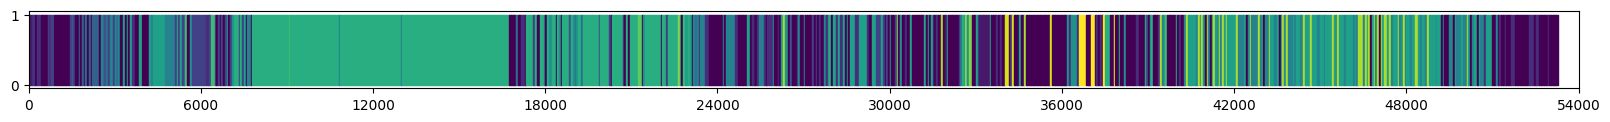

In [ ]:
import matplotlib.pyplot as plt

# 给定的数字列表
segments = [vdic[v] for v in dfVO['V']]

# 获取列表中的唯一值和它们的颜色映射
unique_vals = np.unique(segments)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_vals)))
color_map = dict(zip(unique_vals, colors))

# 为进度条的每一段选择颜色
segment_colors = [color_map[val] for val in segments]

# 绘制进度条
fig, ax = plt.subplots(figsize=(20, 1))
ax.axis('on')  # 关闭坐标轴

for i, (seg, color) in enumerate(zip(segments, segment_colors)):
    ax.fill_between([i, i+1], 0, 1, color=color)

# 设置x轴的限制从0开始
ax.set_xlim(0, len(segments))

# 调整x轴的刻度标签为其30倍
locs = ax.get_xticks()  # 获取当前的x轴刻度位置
ax.set_xticks(locs)
ax.set_xticklabels([int(loc * 60) for loc in locs])

plt.show()

In [ ]:
# 初始化存储结果的列表
results = []

# 初始化当前时间段的开始帧
start_frame = dfVO.iloc[0]['frame']

# 初始化当前动词和名词
current_v = dfVO.iloc[0]['V']
current_o = dfVO.iloc[0]['O']

# 遍历DataFrame中的每一行
for i, row in dfVO.iloc[1:].iterrows():
    # 检查动词和名词是否与当前段的动词和名词相同
    if row['V'] == current_v and row['O'] == current_o:
        # or row['V']=='':
        # 如果相同，继续合并
        continue
    else:
        # 否则，将当前段保存到结果中并开始新的段
        results.append({'frame': f"{start_frame}-{dfVO.iloc[i-1]['frame']}" if start_frame != dfVO.iloc[i-1]['frame'] else f"{start_frame}",
                        'V': current_v, 'O': current_o})
        start_frame = row['frame']
        current_v = row['V']
        current_o = row['O']

# 添加最后一个段
results.append({'frame': f"{start_frame}-{dfVO.iloc[-1]['frame']}" if start_frame != dfVO.iloc[-1]['frame'] else f"{start_frame}",
                'V': current_v, 'O': current_o})

# 将结果转换为DataFrame并保存为CSV
result_df = pd.DataFrame(results)
result_df.to_csv("output2.csv", index=False)

In [ ]:
# 上下文语义合并